# Problem statement

The idea is to forecast the mean of all COVID beds in the US for the upcoming 3 months based on historical data gathered and get the 95% and 80% intervals of the mean value corresponding to each day.

# Loading time series

In [79]:
# Importing the libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
pd.options.display.float_format = '{:.4f}'.format
import pmdarima as pm

In [80]:
# Setting graph/plot parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [81]:
# Loading data
data = pd.read_csv('Hospitalization_all_locs_29th_May_2020.csv')

# Printing first five rows and data type of each column
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

   V1 location_name        date  allbed_mean  allbed_lower  allbed_upper  \
0   1       Abruzzo  2019-12-21       0.0000        0.0000        0.0000   
1   2       Abruzzo  2019-12-22       0.0000        0.0000        0.0000   
2   3       Abruzzo  2019-12-23       0.0000        0.0000        0.0000   
3   4       Abruzzo  2019-12-24       0.0000        0.0000        0.0000   
4   5       Abruzzo  2019-12-25       0.0000        0.0000        0.0000   

   ICUbed_mean  ICUbed_lower  ICUbed_upper  InvVen_mean  ...  \
0       0.0000        0.0000        0.0000       0.0000  ...   
1       0.0000        0.0000        0.0000       0.0000  ...   
2       0.0000        0.0000        0.0000       0.0000  ...   
3       0.0000        0.0000        0.0000       0.0000  ...   
4       0.0000        0.0000        0.0000       0.0000  ...   

   totdea_lower_smoothed  totdea_upper_smoothed  mobility_data_type  \
0                    nan                    nan                 NaN   
1               

# Data Wrangling

* We're grouping by date and applying sum because we have data on states, and all the mean points corresponding to states add up to resemble those for countries. 
* We're also eliminating all rows that have zeroes in mean, lower bound, and upper bound columns

In [82]:
data = data[['date', 'allbed_mean','allbed_lower', 'allbed_upper']].groupby(['date']).sum().reset_index()
data = data[(data['allbed_mean']!=0) & (data['allbed_lower']!=0) & (data['allbed_upper']!=0)]

In [83]:
# Fetching only columns of interest
allBedData = data[['date', 'allbed_mean']]
allBedData.head()

,date,allbed_mean
44,2020-01-26,7.0464
45,2020-01-27,14.0414
46,2020-01-28,21.1169
47,2020-01-29,21.1169
48,2020-01-30,21.1169


### Datetime conversion

Since, date column is having object data type, let's resolve that 

In [84]:
allBedData['date'] = pd.to_datetime(allBedData['date'])

Now, since there are multiple values corresponding to one date because we removed location column from this data, we need to group these dates and find out the final All COVID beds value corresponding to each date.

### Grouping the column by date

In [85]:
allBedData = allBedData.groupby(['date']).sum().reset_index()
allBedData.iloc[50:100]

,date,allbed_mean
50,2020-03-16,47327.2641
51,2020-03-17,55342.3522
52,2020-03-18,63101.6795
53,2020-03-19,71571.2089
54,2020-03-20,80862.0018
55,2020-03-21,90933.8551
56,2020-03-22,101780.5321
57,2020-03-23,113320.3521
58,2020-03-24,125483.7679
59,2020-03-25,138302.4696


In [86]:
#setting index to date
allBedData = allBedData.set_index('date')
allBedData.index

DatetimeIndex(['2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04',
               ...
               '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13',
               '2020-09-14', '2020-09-15'],
              dtype='datetime64[ns]', name='date', length=234, freq=None)

In [87]:
# Keeping historical data till 29th May 2020
allBedData = allBedData[allBedData.index <= '2020-05-29']
allBedData.columns = ['value']
allBedData.tail()

,value
date,
2020-05-25,227355.4546
2020-05-26,225998.8888
2020-05-27,224692.2075
2020-05-28,223523.2237
2020-05-29,222482.1755


### Missing value analysis

We'll check is there's any missing value present in our data by applying isnull function on the dataset.

In [88]:
allBedData.isnull().any()

value    False
dtype: bool

Since, we get 'False' as the result, we can say that there are no missing values in the dataset.

### Detecting outliers

Firstly, let's follow graphical procedure to analyse if the data contains outliers or not. We'll use boxplot for this.

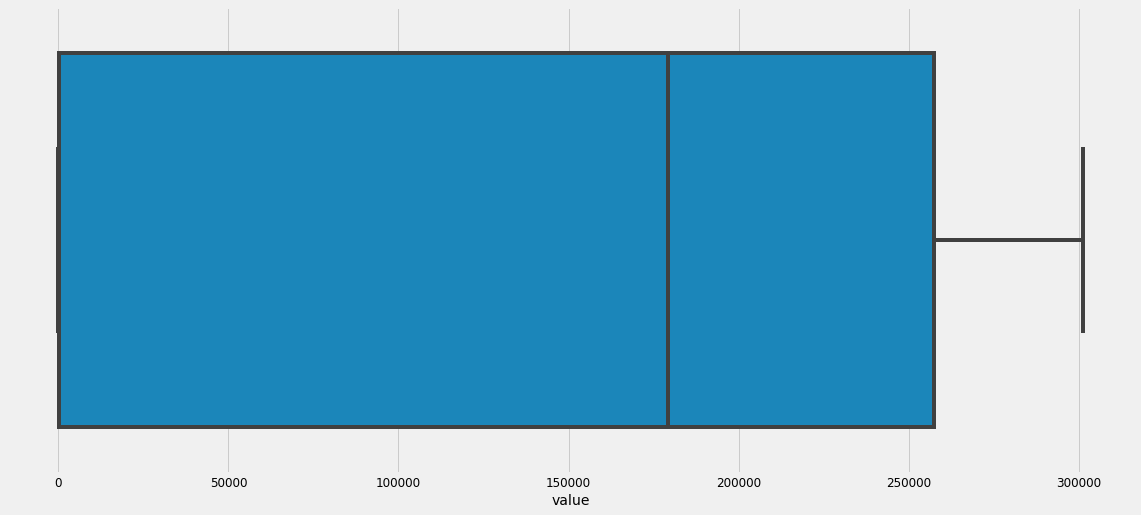

In [89]:
import seaborn as sns
sns.boxplot(x=allBedData['value'])

The boxplot tells that there're no outliers in the data as there's no point which is lying outside of whiskers. Let's now see this via z-scores.

In [90]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(allBedData))
print(z)

[[1.14810579]
 [1.1480491 ]
 [1.14799176]
 [1.14799176]
 [1.14799176]
 [1.14799176]
 [1.14799987]
 [1.14805271]
 [1.14810514]
 [1.14815002]
 [1.14794126]
 [1.14780201]
 [1.14773245]
 [1.14766335]
 [1.14766335]
 [1.14766335]
 [1.14771197]
 [1.14789036]
 [1.14800389]
 [1.14806873]
 [1.14812125]
 [1.14808838]
 [1.14805569]
 [1.14801878]
 [1.14798135]
 [1.14786818]
 [1.14771623]
 [1.14757361]
 [1.14742836]
 [1.14728282]
 [1.14703679]
 [1.14680508]
 [1.14445842]
 [1.14158271]
 [1.13819843]
 [1.13405075]
 [1.12893257]
 [1.12273313]
 [1.11516924]
 [1.10757398]
 [1.09830826]
 [1.08720025]
 [1.07406662]
 [1.0586299 ]
 [1.04114811]
 [1.00813983]
 [0.97037391]
 [0.92769987]
 [0.87948734]
 [0.82520415]
 [0.76461308]
 [0.69965717]
 [0.636774  ]
 [0.5681352 ]
 [0.49284072]
 [0.41121637]
 [0.32331268]
 [0.22979162]
 [0.13121682]
 [0.02733144]
 [0.08098858]
 [0.19194776]
 [0.30433507]
 [0.41747948]
 [0.52994797]
 [0.6382473 ]
 [0.74135714]
 [0.83755508]
 [0.92653894]
 [1.00656662]
 [1.07583919]
 [1.13

As can be seen from above array, every value has z-score less than +3 or greater than -3. Thus, no outliers are present in the data.

# Time-series analysis

### Extracting time series from dataframe

In [91]:
# Converting allBedData into time-series
ts = allBedData['value']
ts.head()

date
2020-01-26    7.0464
2020-01-27   14.0414
2020-01-28   21.1169
2020-01-29   21.1169
2020-01-30   21.1169
Name: value, dtype: float64

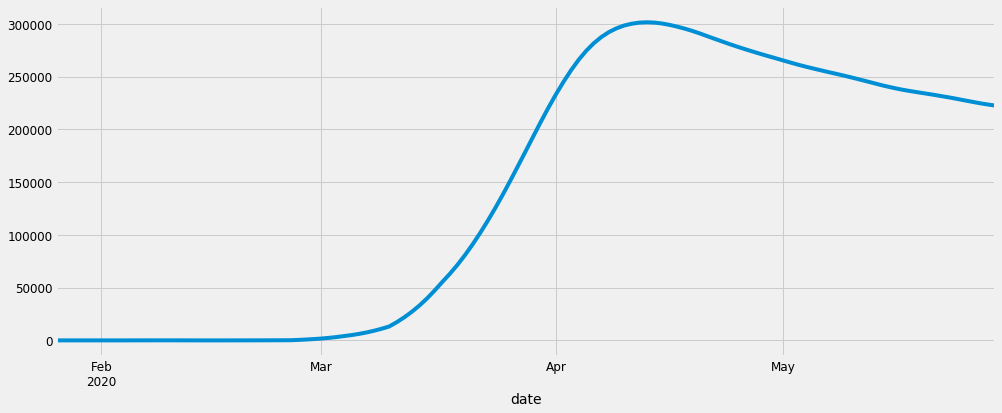

In [92]:
# Visualizing the time-series
pd.plotting.register_matplotlib_converters()
ts.plot(figsize=(15, 6))
plt.show()

The time-series stays close to 0 till the end of February 2020 and begins increasing after that. It keeps on increasing till mid-April where it reaches the highest point and then begins decreasing.

### Decomposing the time-series

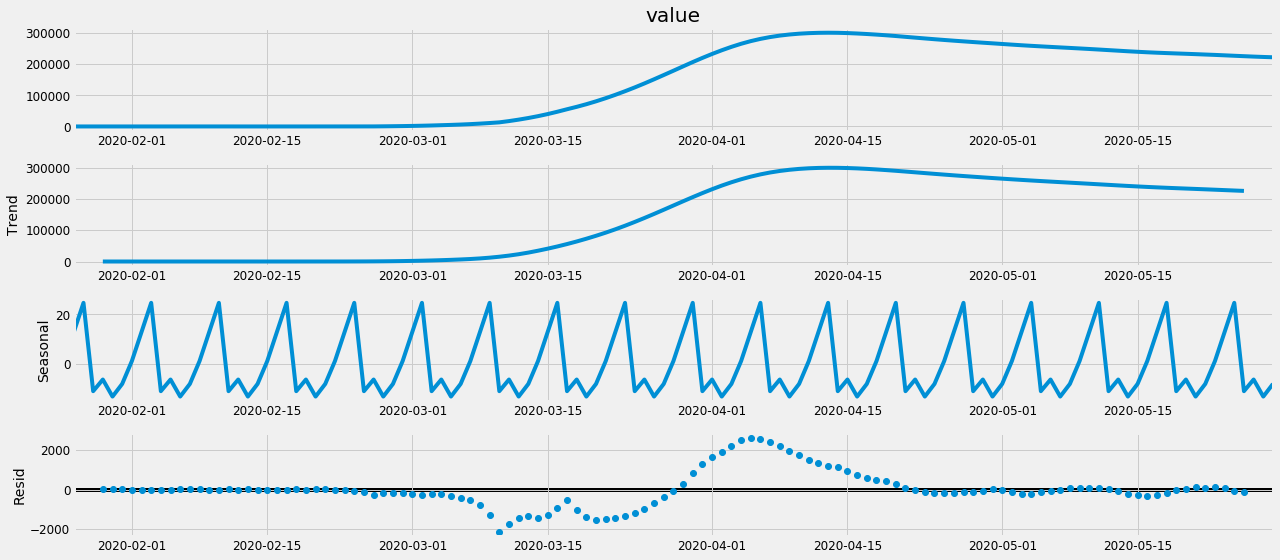

In [93]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

We can see that besides trend, there is high amount of seasonality within the data.

# Checking Stationarity

 In a time-series, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

In [94]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

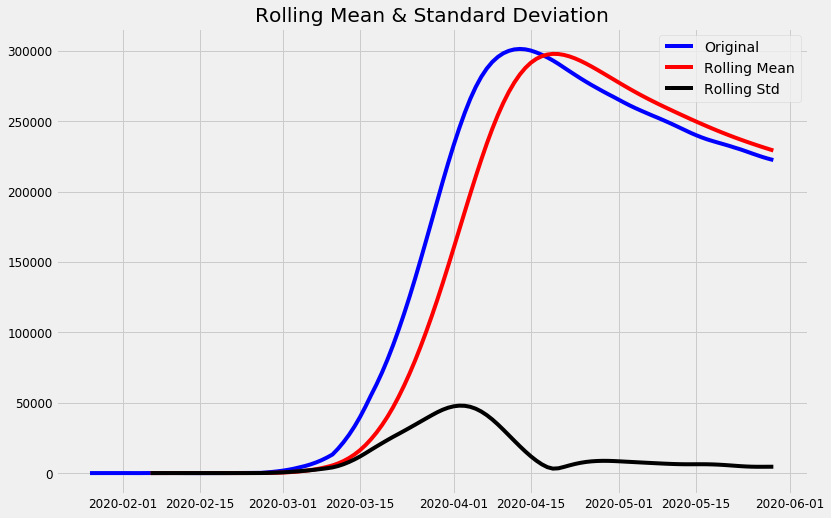

Results of Dickey-Fuller Test:
p-value = 0.5811. The series is likely non-stationary.
Test Statistic                 -1.4024
p-value                         0.5811
#Lags Used                      9.0000
Number of Observations Used   115.0000
Critical Value (1%)            -3.4885
Critical Value (5%)            -2.8870
Critical Value (10%)           -2.5804
dtype: float64


In [95]:
test_stationarity(ts)

We can see that this time-series is non-stationary with p value of 0.58.

# Plotting ACF and PACF 

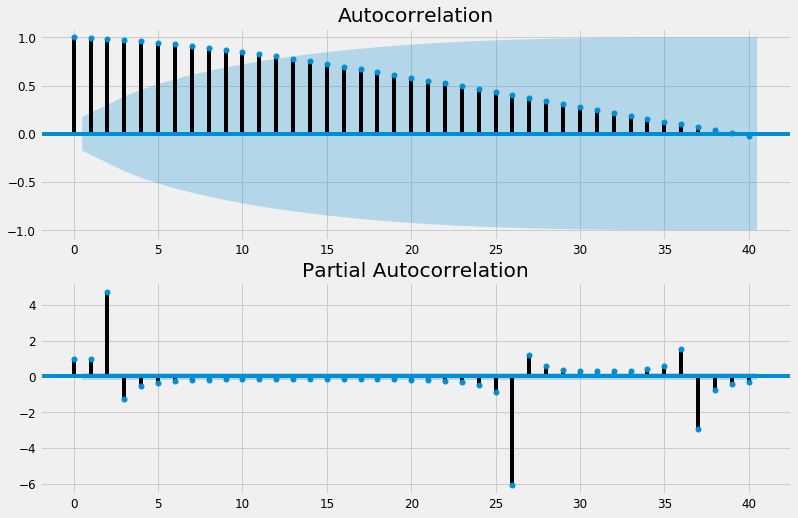

In [96]:
# Plotting ACF
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)# , lags=40

Since seasonality is also present in the data as can be seen from above graphs, after 15 days, we're seeing some sine wave like pattern, let's consider SARIMA.

# Forecasting the time-series with ARIMA

### Understanding ARIMA

ARIMA, an acronym for Autoregressive Integrated Moving Average, is a combination of two terms - (i) AR (ii) MA
* AR corresponds to the difference value. This is today's value minus yesterday's value or value-on-value change.
* MA corresponds to moving average terms.

Besides this, we have seen that there's high amount of seasonality in the time-series. Therefore, we will be using Seasonal ARIMA or SARIMA in this case.

# ARIMA

In [97]:
import pmdarima as pm

In [98]:
# Keeping the p, d and q to be bounded in (0,3)
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
#pdq = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for  ARIMA...')
print('ARIMA: {}'.format(pdq[1]))
print('ARIMA: {}'.format(pdq[2]))
print('ARIMA: {}'.format(pdq[3]))
print('ARIMA: {}'.format(pdq[4]))

Examples of parameter combinations for  ARIMA...
ARIMA: (0, 0, 1)
ARIMA: (0, 0, 2)
ARIMA: (0, 1, 0)
ARIMA: (0, 1, 1)


In [99]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [100]:
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
for x in pdq:
    try:
        #print(x)
        mod = ARIMA(ts, order =x)
        mod_fit = mod.fit()
        print('ARIMA{} - AIC:{}'.format(x, mod_fit.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:3289.516530568797
ARIMA(0, 1, 0) - AIC:2453.985826612582
ARIMA(0, 2, 0) - AIC:1864.073287619416
ARIMA(0, 2, 1) - AIC:1788.7423418006506
ARIMA(0, 2, 2) - AIC:1754.1197074293118
ARIMA(1, 1, 1) - AIC:1808.9621345122675
ARIMA(1, 1, 2) - AIC:1774.2435242590714
ARIMA(1, 2, 0) - AIC:1699.3642190924934
ARIMA(1, 2, 1) - AIC:1689.6732177984672
ARIMA(1, 2, 2) - AIC:1690.6549148022832
ARIMA(2, 0, 1) - AIC:1816.8023316995573
ARIMA(2, 0, 2) - AIC:1787.0486258255078
ARIMA(2, 1, 1) - AIC:1699.3859203035586
ARIMA(2, 1, 2) - AIC:1700.9322914256343
ARIMA(2, 2, 0) - AIC:1689.908898231465
ARIMA(2, 2, 1) - AIC:1691.0745599674722
ARIMA(2, 2, 2) - AIC:1684.396393214751


We can see that (2, 2, 2) - AIC:1684.3964 corresponds to the lowest AIC value of 1684.3964.

# Running diagnosis

In [257]:
mod = ARIMA(ts,order=(2, 2, 2))
                                
results = mod.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  123
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -836.198
Method:                       css-mle   S.D. of innovations            215.245
Date:                Sun, 07 Jun 2020   AIC                           1684.396
Time:                        11:43:38   BIC                           1701.269
Sample:                    01-28-2020   HQIC                          1691.250
                         - 05-29-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.3531     98.826     -0.014      0.989    -195.049     192.343
ar.L1.D2.value     1.8973      0.075     25.292      0.000       1.750       2.044
ar.L2.D2.value    -0.9157      0.068

In [270]:
m = pm.ARIMA(order=(2,2,2))
z = m.fit(ts)

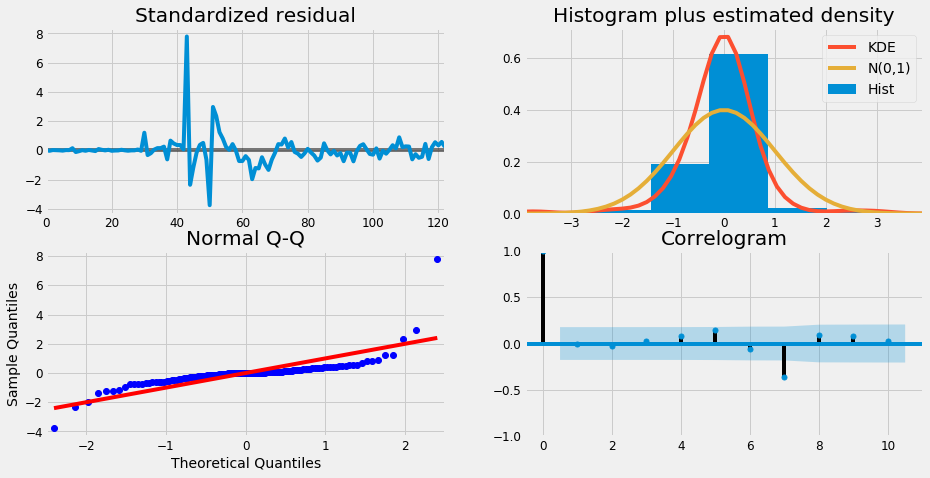

In [300]:
z.plot_diagnostics(figsize=(14, 7));

The above plots say that:
* The standardized residual follow random behaviour and thus corresponding to random noise.
* The histogram suggests that the residuals have normal distribution.
* The Normal Q-Q plot suggests that the theoretical and sample quantiles are very close to each other. The more close the sample quantiles to the line, the more normal their distribution will be. The points approximately lie on the red line.
* The correlogram has all autocorrelation of different lags in between the blue shaded area.

The diagnosis say that model is quite good.

Text(0.5, 1.0, 'Residual distribution')

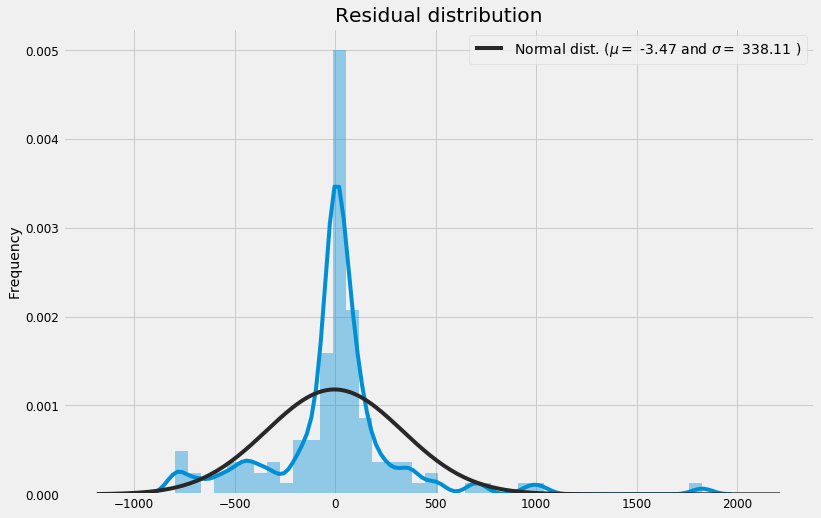

In [146]:
resid = z.resid()

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit= stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

We can see that the residuals are near normally distributed with kurtosis being a little high. 

# Validating forecasts

Choosing 35th number in z.predict(len(ts)) (the 1st of March) as a reference point to start validating the forecasts.

In [322]:
# z.predict(len(ts))

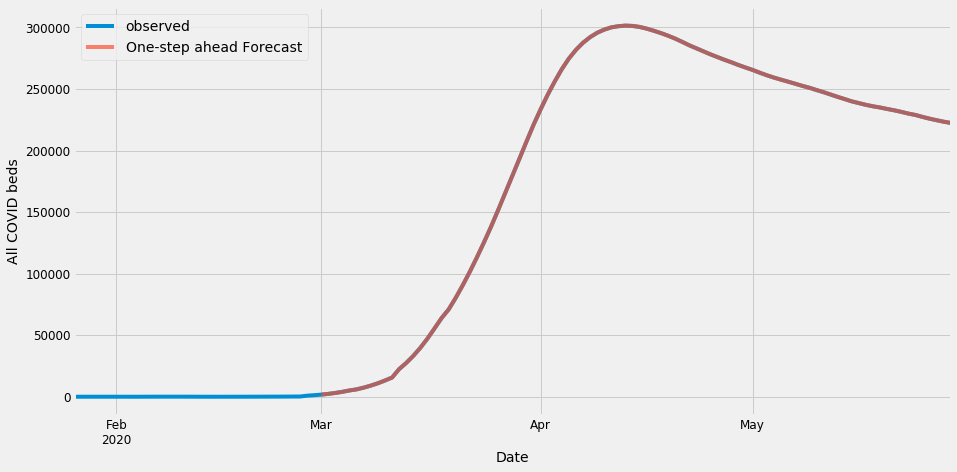

In [306]:
pred_int = z.predict_in_sample(start = 35, return_conf_int=True, alpha = 0.05)
df_pred = allBedData[35:]
df_pred['value'] = pred_int[0]
ts_pred = df_pred['value']
ax = ts.plot(label='observed')
ts_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_int[0], pred_int[1][:,0], pred_int[1][:,1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

In [309]:
ts_truth = ts['2020-04-01':]
df_pred = allBedData[len(ts_truth):]
pred_int = z.predict_in_sample(start = len(ts_truth), return_conf_int=True, alpha = 0.05)
df_pred['value'] = pred_int[0]
ts_forecasted = df_pred['value']
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [323]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.0


In [327]:
ts.min()

1.58902023809524

In [325]:
ts.max()

301464.57850377244

This means that the value of RMSE is 0.0. Also, the minimum and maximum values of time series is 57.08462142857141 and 293961.92172662885 respectively. Overall, this is a very good model so far.

# Visualizing Forecast

In [310]:
from datetime import date, timedelta, datetime
next_100_days = []
datetime_str = '2020-05-29'
datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d')
for j in range(1, 101, 1):
        next_100_days.append((datetime_object + timedelta(days=j)).date())

In [311]:
next_100_days[0:6]

[datetime.date(2020, 5, 30),
 datetime.date(2020, 5, 31),
 datetime.date(2020, 6, 1),
 datetime.date(2020, 6, 2),
 datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 4)]

In [328]:
df_ci.predicted_mean

date
2020-05-30   221548.7376
2020-05-31   220725.6652
2020-06-01   220013.4106
2020-06-02   219410.3049
2020-06-03   218912.7638
                 ...    
2020-09-02   185512.8257
2020-09-03   184965.7850
2020-09-04   184418.0152
2020-09-05   183869.5022
2020-09-06   183320.1990
Name: predicted_mean, Length: 100, dtype: float64

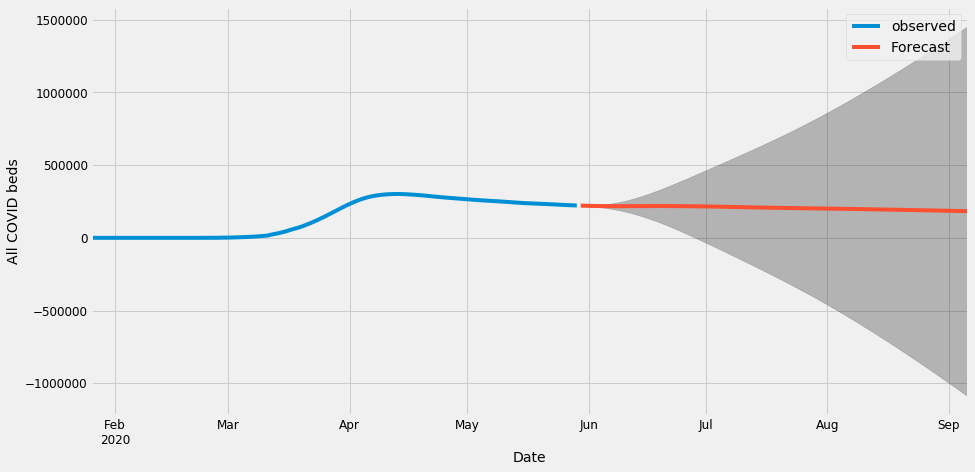

In [312]:
# Using the default confidence interval - 95%
pred_uc = z.predict(100, return_conf_int=True, alpha = 0.05)
pred_ci = pred_uc[0]

df_ci = pd.DataFrame(columns=['date', 'predicted_mean', 'lower', 'upper'])
df_ci['predicted_mean'] = pred_uc[0]
df_ci['date'] = next_100_days
df_ci['lower'] = pred_uc[1][:,0]
df_ci['upper'] = pred_uc[1][:,1]
df_ci['date'] = pd.to_datetime(df_ci['date'])
df_ci = df_ci.set_index('date')


# df_ci_2['date'] = next_100_days
# df_ci_2 = df_ci_2.set_index('date')
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(df_ci.index,
                df_ci.iloc[:, 1],
                df_ci.iloc[:, 2], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

Thus, in the future, the number of all COVID beds will keep decreasing. The upper and lower limits are shaded in gray. It is to be noted that as the timeline increases, the uncertainty increases and band of confidence increases.

In [313]:
df_ci.head()

,predicted_mean,lower,upper
date,,,
2020-05-30,221548.7376,221126.3905,221971.0848
2020-05-31,220725.6652,219581.5074,221869.8230
2020-06-01,220013.4106,217767.2812,222259.5399
2020-06-02,219410.3049,215633.9460,223186.6637
2020-06-03,218912.7638,213135.5213,224690.0064


In [314]:
# Setting all negative forecasted values to be 0
df_ci.predicted_mean[df_ci.predicted_mean < 0] = 0
df_ci.predicted_mean

date
2020-05-30   221548.7376
2020-05-31   220725.6652
2020-06-01   220013.4106
2020-06-02   219410.3049
2020-06-03   218912.7638
                 ...    
2020-09-02   185512.8257
2020-09-03   184965.7850
2020-09-04   184418.0152
2020-09-05   183869.5022
2020-09-06   183320.1990
Name: predicted_mean, Length: 100, dtype: float64

In [315]:
df_ci['lower'][df_ci['lower'] < 0] = 0
df_ci['upper'][df_ci['upper'] < 0] = 0
df_ci

,predicted_mean,lower,upper
date,,,
2020-05-30,221548.7376,221126.3905,221971.0848
2020-05-31,220725.6652,219581.5074,221869.8230
2020-06-01,220013.4106,217767.2812,222259.5399
2020-06-02,219410.3049,215633.9460,223186.6637
2020-06-03,218912.7638,213135.5213,224690.0064
...,...,...,...
2020-09-02,185512.8257,0.0000,1387552.1728
2020-09-03,184965.7850,0.0000,1405513.7256
2020-09-04,184418.0152,0.0000,1423565.0910


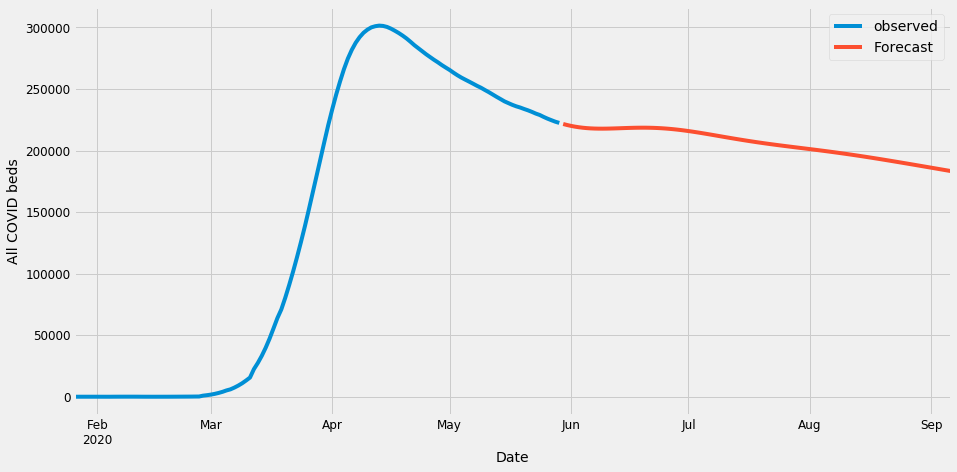

In [316]:
# Obtaining refined plots
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

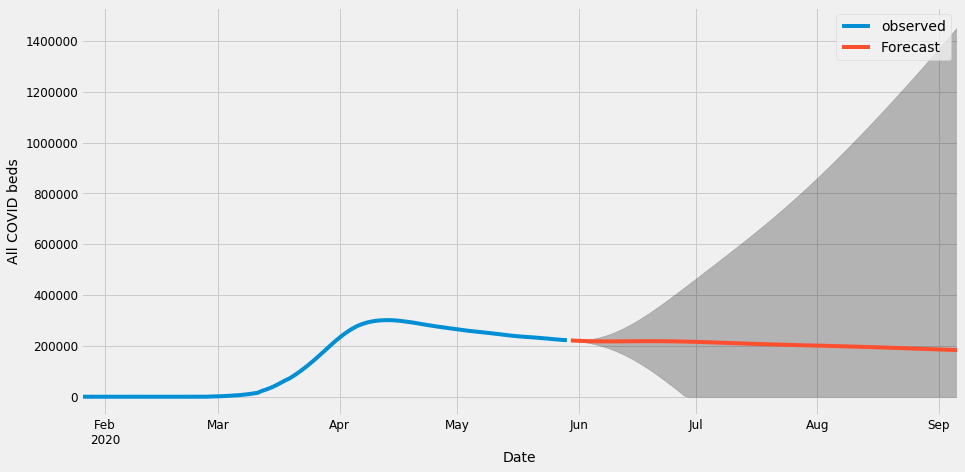

In [317]:
ax = ts.plot(label='observed', figsize=(14, 7))
df_ci.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(df_ci.index,
                df_ci.iloc[:, 1],
                df_ci.iloc[:, 2], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

In [318]:
# Predictions dataframe
AllBedsPredictions = pd.DataFrame({'Predicted Mean All Beds':df_ci.predicted_mean, 
                                   'Predicted lower value':df_ci.iloc[:, 1], 
                                  'Predicted upper value': df_ci.iloc[:, 2]})

In [319]:
AllBedsPredictions.head(25)

,Predicted Mean All Beds,Predicted lower value,Predicted upper value
date,,,
2020-05-30,221548.7376,221126.3905,221971.0848
2020-05-31,220725.6652,219581.5074,221869.8230
2020-06-01,220013.4106,217767.2812,222259.5399
2020-06-02,219410.3049,215633.9460,223186.6637
2020-06-03,218912.7638,213135.5213,224690.0064
2020-06-04,218515.5117,210230.8735,226800.1498
2020-06-05,218211.8176,206884.3728,229539.2625
2020-06-06,217993.7397,203066.2801,232921.1992
2020-06-07,217852.3705,198752.9471,236951.7939


# SARIMA

In [148]:
# Keeping the p, d and q to be bounded in (0,3)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


This step is parameter selection for our SARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model. Parameters corresponding to lowest AIC are the ones that we'd choose.

In [180]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3366.4946595258234
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2986.3261627364504
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:2860.3196077090224
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2788.9351086622537
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2455.246974439689
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:2170.4094181864475
SARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:2476.2112222265673
SARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:2167.0111438798895
SARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:1882.221660825391
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2813.2889830691083
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2735.7140250113544
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:2497.750884124601
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2478.2990159443216
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2423.7987249752573
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:2157.6255993686036
SARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:2208.7573341109614
SARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:2159.852066699432
SARIMA(0, 0, 0)x(1, 2, 2, 12)12 - A

SARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:1848.523092732626
SARIMA(0, 1, 2)x(1, 0, 2, 12)12 - AIC:1712.9882938174278
SARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:1784.38389463202
SARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:1695.3120141882712
SARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:1579.537366599995
SARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:1627.9519475882194
SARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:1514.5674275670037
SARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:1296.6899659770986
SARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:1708.5764056042515
SARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:1840.2344822896791
SARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:1692.442029168395
SARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:1534.4192352591263
SARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:1530.4253135947552
SARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:1475.9336747051086
SARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:1392.0957244100532
SARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:1347.5094340505286
SARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:1440.6805043659883
SARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AI

SARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:2058.8932986558766
SARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:1629.390458201483
SARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:1689.303253099321
SARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:1670.2856551417146
SARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:1505.0401337256558
SARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:1503.8609158810839
SARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:1485.8578619303773
SARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:2125.980702462248
SARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:2055.590446298487
SARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:2802.9569107951534
SARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:1915.7266179760952
SARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:1866.6631343961574
SARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:1801.3400115952643
SARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:1925.7814903216688
SARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:1691.9657833932376
SARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:1458.6581036773919
SARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:1933.7690192090215
SARIMA(1, 0, 2)x(1, 0, 1, 12)12 - A

SARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:1370.0937806501631
SARIMA(1, 2, 1)x(0, 1, 2, 12)12 - AIC:1215.1720661444422
SARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:1538.1451504470147
SARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:1283.8473038090672
SARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:1063.758756371896
SARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:1521.4447616315647
SARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:1510.6116707676672
SARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:1352.3098971934235
SARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:1414.30519708857
SARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1370.189579527187
SARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:1207.8541795134531
SARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:1324.5714868692417
SARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:1261.7031763555087
SARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:1065.2366281590512
SARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:1369.188144757355
SARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:1371.187594083498
SARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:1347.873652706248
SARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:

SARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:1253.5228269267955
SARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:1333.9018623096667
SARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:1277.4303377693598
SARIMA(2, 1, 0)x(1, 2, 2, 12)12 - AIC:1113.5958084705032
SARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:1378.6364024116192
SARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:1370.7153740323708
SARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC:1365.7037834434484
SARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:1245.4222229408758
SARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:1235.984807726069
SARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:1232.9593600009844
SARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:1103.014177148103
SARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:1084.6839902920628
SARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:1131.0962291416456
SARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:1666.4858455257122
SARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:1583.263791322283
SARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:1375.6793989215098
SARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:1593.269791024101
SARIMA(2, 1, 1)x(0, 1, 1, 12)12 - A

SARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:1089.11477776784
SARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:1116.2486827926205
SARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:1103.4317449332948


We can see that (1, 2, 2)x(0, 2, 2, 12)12 - AIC:1045.545 corresponds to the lowest AIC value of 1045.544.

# Fitting the SARIMA model

In [165]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 2, 2),
                                seasonal_order=(0, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  125
Model:             SARIMAX(1, 2, 2)x(0, 2, 2, 12)   Log Likelihood                -516.772
Date:                            Sat, 06 Jun 2020   AIC                           1045.545
Time:                                    20:23:46   BIC                           1059.205
Sample:                                01-26-2020   HQIC                          1050.983
                                     - 05-29-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9492      0.051     18.481      0.000       0.849       1.050
ma.L1         -0.2972      0.090   

We can see that the model has the following features: 

* kurtosis of 8.43, close to 0
* Jarque-Bera statistic of 124.35 (not close to zero) 
* All the above points mean that the model is close to normal distribution
* Also, AIC (1045.545) is not very low.

Thus, so far, we can see that statistics suggest we are having very good model.

# Running diagnosis

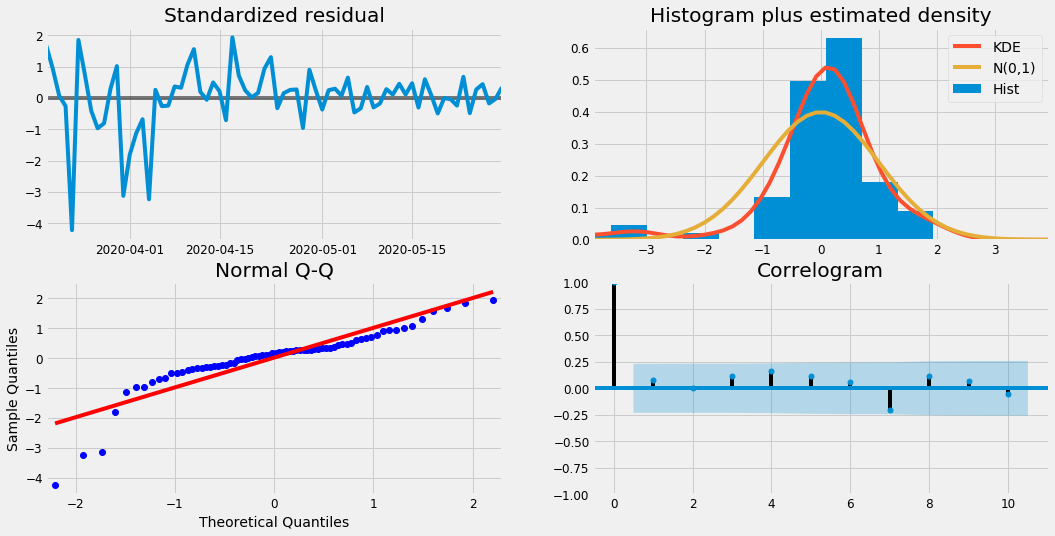

In [166]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The above plots say that:
* The standardized residual follow random behaviour and thus corresponding to random noise.
* The histogram suggests that the residuals have normal distribution.
* The Normal Q-Q plot suggests that the theoretical and sample quantiles are very close to each other. The more close the sample quantiles to the line, the more normal their distribution will be. The points approximately lie on the red line.
* The correlogram has all autocorrelation of different lags in between the blue shaded area.

The diagnosis say that model is quite good.

Text(0.5, 1.0, 'Residual distribution')

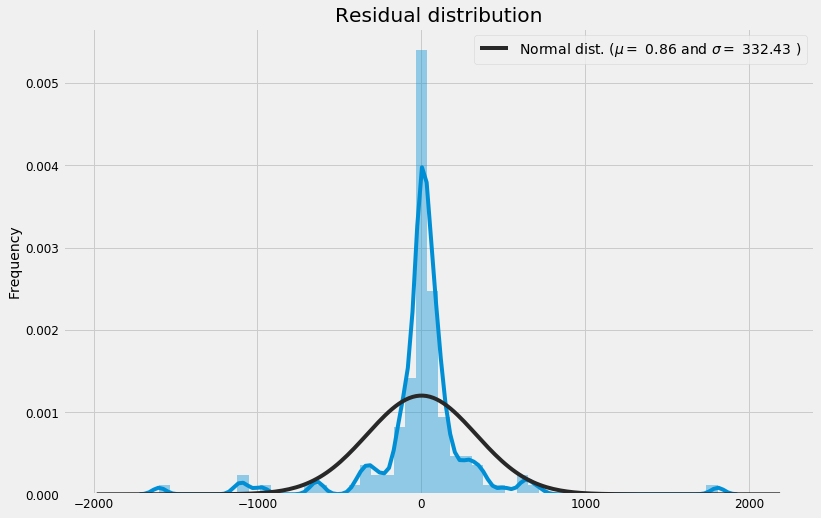

In [167]:
resid = results.resid

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

We can see that the residuals are near normally distributed with kurtosis being a little high. 

# Validating forecasts

Choosing March as a reference point to start validating the forecasts.

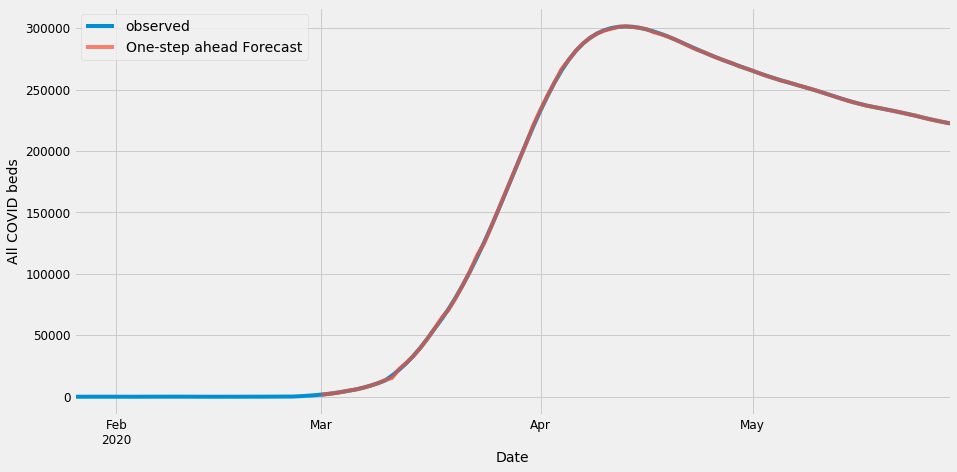

In [168]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.

In [169]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['2020-04-01':]
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 60405.96


The MSE is very low.

In [170]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 245.78


In [171]:
ts.min()

1.58902023809524

In [172]:
ts.max()

301440.80169198266

This means that the value of RMSE is 245.78. Also, the minimum and maximum values of time series is 1.589 and 301440.802 respectively. Overall, this is a very good model so far.

# Visualizing forecasts

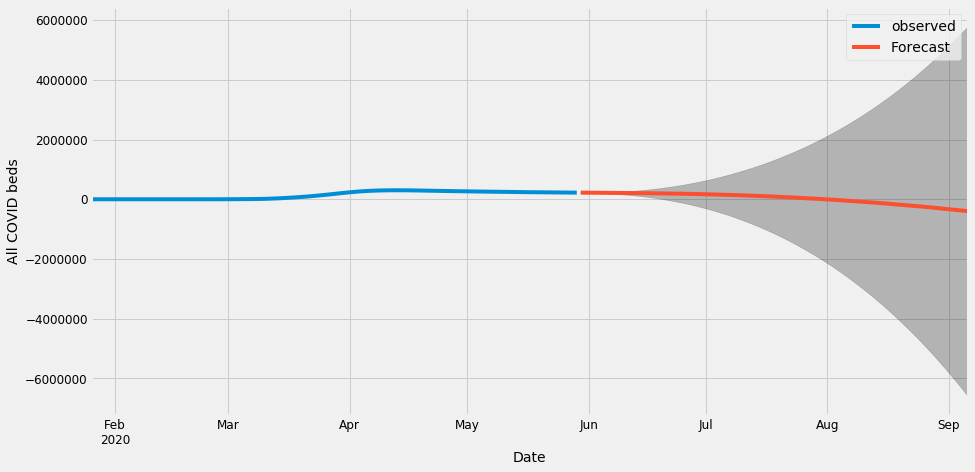

In [173]:
# Using the default confidence interval - 95%
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

Thus, in the future, the number of all COVID beds will keep decreasing. The upper and lower limits are shaded in gray. It is to be noted that as the timeline increases, the uncertainty increases and band of confidence increases.

In [174]:
# Setting all negative forecasted values to be 0
pred_uc.predicted_mean[pred_uc.predicted_mean < 0] = 0
pred_uc.predicted_mean

2020-05-30   221580.7464
2020-05-31   220762.6235
2020-06-01   220006.0236
2020-06-02   219215.0933
2020-06-03   218342.3996
                 ...    
2020-09-02        0.0000
2020-09-03        0.0000
2020-09-04        0.0000
2020-09-05        0.0000
2020-09-06        0.0000
Freq: D, Length: 100, dtype: float64

In [175]:
pred_ci['lower value'][pred_ci['lower value'] < 0] = 0
pred_ci['upper value'][pred_ci['upper value'] < 0] = 0
pred_ci

,lower value,upper value
2020-05-30,221032.8458,222128.6470
2020-05-31,219209.8547,222315.3924
2020-06-01,216864.9341,223147.1131
2020-06-02,213840.1473,224590.0394
2020-06-03,210039.4852,226645.3140
...,...,...
2020-09-02,0.0000,5272098.4253
2020-09-03,0.0000,5404354.6790
2020-09-04,0.0000,5539041.2254
2020-09-05,0.0000,5676222.0626


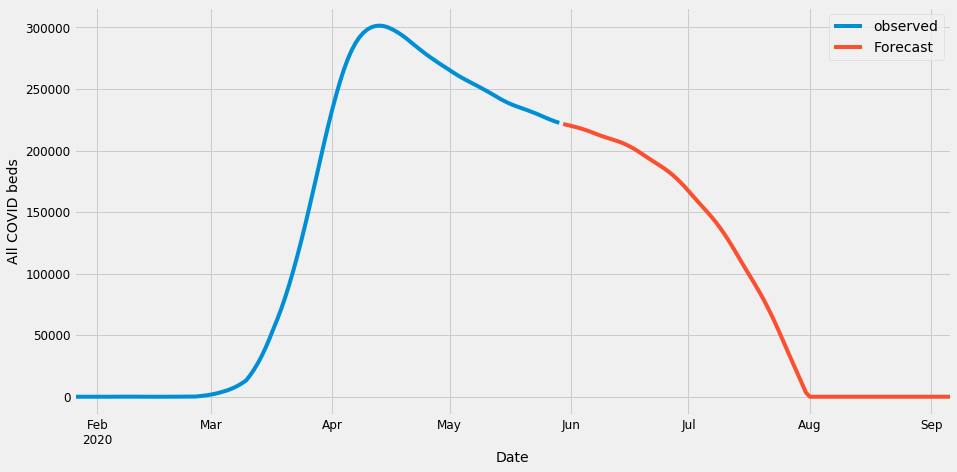

In [176]:
# Obtaining refined plots
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

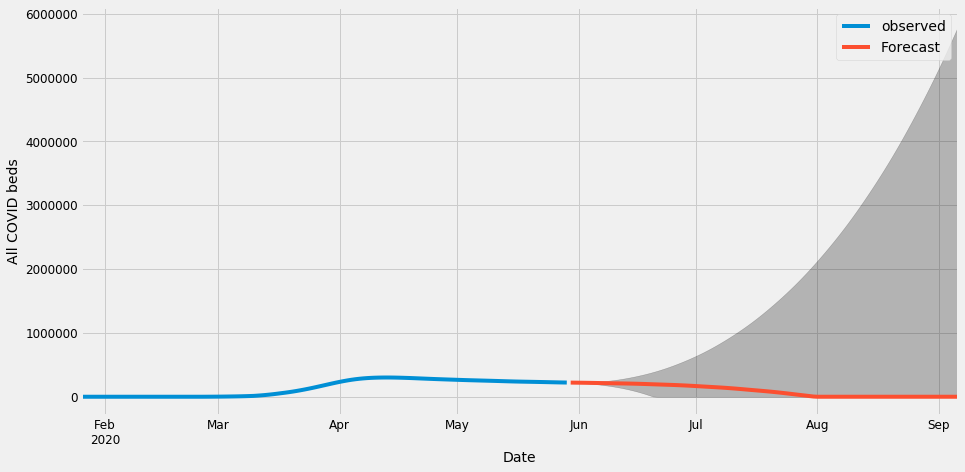

In [177]:
ax = ts.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('All COVID beds')
plt.legend()
plt.show()

In [178]:
# Predictions dataframe
AllBedsPredictions = pd.DataFrame({'Predicted Mean All Beds':pred_uc.predicted_mean, 
                                   'Predicted lower value':pred_ci.iloc[:, 0], 
                                  'Predicted upper value': pred_ci.iloc[:, 1]})

In [179]:
AllBedsPredictions.head(25)

,Predicted Mean All Beds,Predicted lower value,Predicted upper value
2020-05-30,221580.7464,221032.8458,222128.6470
2020-05-31,220762.6235,219209.8547,222315.3924
2020-06-01,220006.0236,216864.9341,223147.1131
2020-06-02,219215.0933,213840.1473,224590.0394
2020-06-03,218342.3996,210039.4852,226645.3140
2020-06-04,217403.3610,205439.4887,229367.2333
2020-06-05,216357.1920,199968.0019,232746.3821
2020-06-06,215204.1078,193599.8872,236808.3284
2020-06-07,213967.5893,186338.2413,241596.9373
2020-06-08,212739.3203,178258.5808,247220.0597
